Trabajo Práctico Final

Materia: Aprendizaje de Máquina

Alumno: Mauro Nievas Offidani

---



# Introducción

La generación de descripciones de imágenes (image captioning) consiste en la producción de texto descriptivo a partir de una imagen dada. En el presente trabajo, se entrenó un modelo de generación de descripciones utilizando la base de datos Flickr 30k. Durante el pre-procesamiento de los datos se utilizaron los embeddings Glove (pre-procesamiento de texto) y el modelo InceptionV3 (pre-procesamiento de imágenes). Finalmente, para el testeo del modelo, se utilizó el score BLEU (Bilingual Evaluation Understudy).

# Librerías

In [ ]:
from google.colab import files
import pickle
from pickle import dump, load

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
from tqdm import tqdm
import string
import re
import random

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model
from tensorflow.keras.utils import pad_sequences
from keras.utils import to_categorical
from numpy import array
from keras import Input
from keras.layers import Dropout, Dense, Embedding, LSTM
from keras.layers import add
from keras.optimizers import Adam
from nltk.translate.bleu_score import corpus_bleu

# Descargas

## Base de datos: flickr 30k

In [ ]:
! pip install -q kaggle

In [ ]:
# Cargo el archivo kaggle.json. Para conseguirlo, hay que abrir la cuenta de Kaggle y usar la opción Expire API y luego Create New API Token en la sección API.

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mauronievasoffidani","key":"a2de8e7d642bc91de879c544750d06b9"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
# Muevo el archivo kaggle.json al directorio /kaggle.

! cp kaggle.json ~/.kaggle/

In [ ]:
# Descargo el dataset.

! kaggle datasets download -d hsankesara/flickr-image-dataset

100% 8.16G/8.16G [00:51<00:00, 225MB/s]
100% 8.16G/8.16G [00:51<00:00, 169MB/s]


In [ ]:
! mkdir caption_data

In [ ]:
%%capture
! unzip flickr-image-dataset.zip -d caption_data

## Embeddings: Glove

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2022-11-15 19:12:16--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-11-15 19:12:16--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-11-15 19:12:16--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


# Base de datos

## Ejemplos de imágenes y descripciones

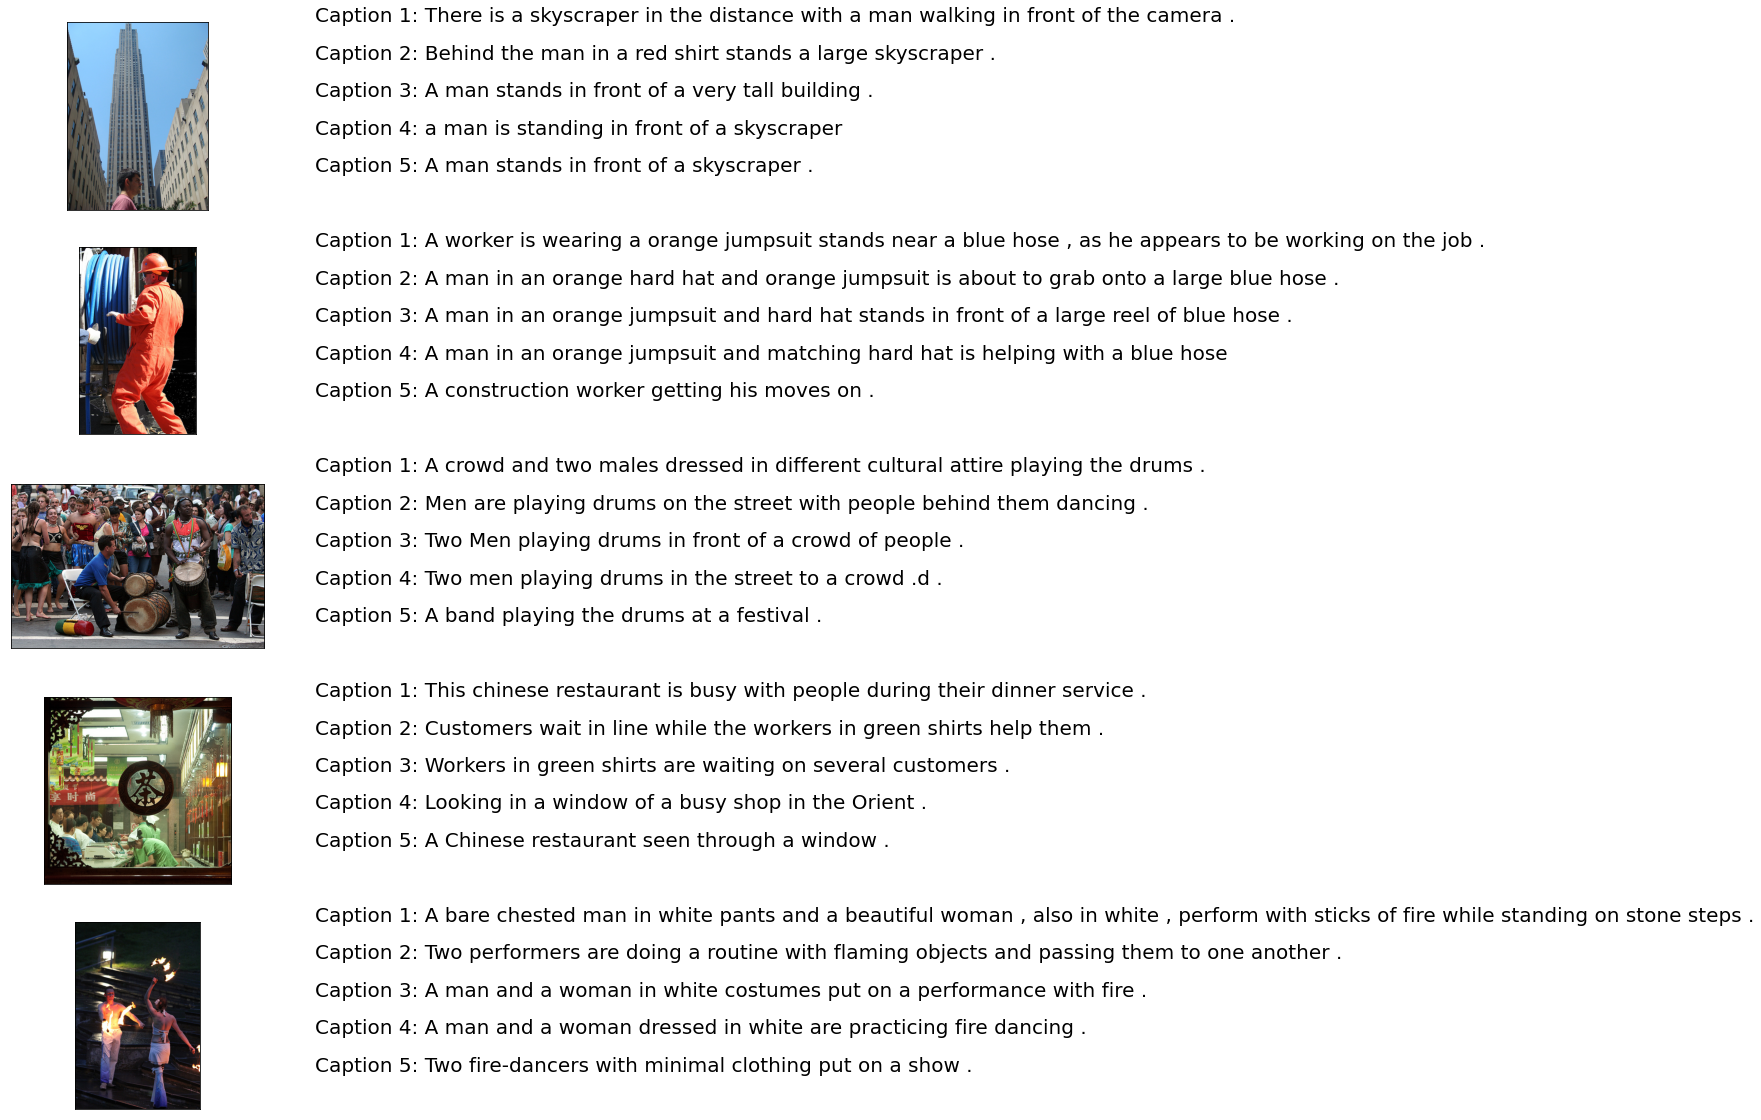

In [ ]:
# Muestro 5 imágenes al azar junto a sus respectivas descripciones.

caption_df = pd.read_csv('caption_data/flickr30k_images/flickr30k_images/results.csv', delimiter='|', skipinitialspace = True)
keys = caption_df['image_name'].apply(lambda x: x.split('.')[0]).unique()
random_keys = np.random.choice(keys, 5, replace = False)

npic = 5
count = 1
fig = plt.figure(figsize=(10,20))
for idx, key in enumerate(random_keys):
  image_path = 'caption_data/flickr30k_images/flickr30k_images/' + key + '.jpg'
  image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
  ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
  ax.imshow(np.squeeze(image))
  count += 1

  captions = caption_df[caption_df['image_name'] == key + '.jpg']['comment'].values

  ax = fig.add_subplot(npic,2,count)
  plt.axis('off')
  ax.plot()
  ax.set_xlim(0,1)
  ax.set_ylim(0,len(captions))
  for idx, caption in enumerate(captions):
    new_text = 'Caption ' + str(idx +1) + ': ' + caption
    ax.text(0,5-idx,new_text,fontsize=20)
  count += 1
plt.show()

## Pre-procesamiento de texto

In [ ]:
# Importo las descripciones textuales (captions)

captions = pd.read_csv('caption_data/flickr30k_images/flickr30k_images/results.csv', delimiter='|', skipinitialspace = True)

In [ ]:
captions['image_key'] = captions['image_name'].apply(lambda x: x.split('.')[0])

In [ ]:
captions.head()

,image_name,comment_number,comment,image_key
0,1000092795.jpg,0,Two young guys with shaggy hair look at their ...,1000092795
1,1000092795.jpg,1,"Two young , White males are outside near many ...",1000092795
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .,1000092795
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .,1000092795
4,1000092795.jpg,4,Two friends enjoy time spent together .,1000092795


In [ ]:
captions['caption_dict'] = captions.apply(lambda x: {'image_key': x['image_key'], 'caption_key': x['image_key'] + '_' + str(x['comment_number']), 'text': str(x['comment'])}, axis = 1)

In [ ]:
caption_data = captions.groupby(['image_key']).agg({'caption_dict': lambda x: x.tolist()}).reset_index()

In [ ]:
caption_data.head()

,image_key,caption_dict
0,1000092795,"[{'image_key': '1000092795', 'caption_key': '1..."
1,10002456,"[{'image_key': '10002456', 'caption_key': '100..."
2,1000268201,"[{'image_key': '1000268201', 'caption_key': '1..."
3,1000344755,"[{'image_key': '1000344755', 'caption_key': '1..."
4,1000366164,"[{'image_key': '1000366164', 'caption_key': '1..."


In [ ]:
training_split = 0.80

In [ ]:
training_captions = caption_data.sample(frac = training_split, random_state = 7)
test_captions = caption_data.drop(training_captions.index)

In [ ]:
len(training_captions), len(test_captions)

(25426, 6357)

In [ ]:
training_captions['caption_dict'][0]

[{'image_key': '1000092795',
  'caption_key': '1000092795_0',
  'text': 'Two young guys with shaggy hair look at their hands while hanging out in the yard .'},
 {'image_key': '1000092795',
  'caption_key': '1000092795_1',
  'text': 'Two young , White males are outside near many bushes .'},
 {'image_key': '1000092795',
  'caption_key': '1000092795_2',
  'text': 'Two men in green shirts are standing in a yard .'},
 {'image_key': '1000092795',
  'caption_key': '1000092795_3',
  'text': 'A man in a blue shirt standing in a garden .'},
 {'image_key': '1000092795',
  'caption_key': '1000092795_4',
  'text': 'Two friends enjoy time spent together .'}]

In [ ]:
def preprocess_text(caption_data, dataset_type = 'training', saving_directory = 'preprocessed_data', vocab_threshold = -1,
                    embedding_path = 'glove.6B.200d.txt', embedding_dim = 200):

  chars = re.escape(string.punctuation)

  # Para la normalización de textos, cambio las letras mayúsculas a minúsculas, elimino caracteres especiales y agrego tokens de inicio y final.

  def normalize_text(s, removed_chars = chars):
    new_s = s.lower()
    new_s = re.sub(r'['+removed_chars+']', '',new_s)
    new_s = '<START> ' + new_s + ' <END>'
    new_s = new_s.replace('  ', ' ')
    return new_s

  def add_preprocessed_text(dict_list, normalization_function):
    for dct in dict_list:
      dct['preprocessed_text'] = normalization_function(dct['text'])
      dct['caption_tokens'] = [t for t in dct['preprocessed_text'].split()]

  caption_data['caption_dict'].apply(lambda x: add_preprocessed_text(x, normalize_text))

  # Creo la lista de tokens y calculo el máximo largo de las descripciones.
  caption_tokens = []
  tokens = []
  max_len = 0

  for lst in caption_data['caption_dict']:
    for dct in lst:
      tokens += dct['caption_tokens']
      if max_len < len(dct['caption_tokens']):
        max_len = len(dct['caption_tokens'])

  print('max sentence length:', max_len)

  # Creo un diccionario de tokens y filtro según la frecuencia mínima (vocab_threshold).
  vocab = {}
  for token in tokens:
    if token not in vocab.keys():
      vocab[token] = 1
    else:
      vocab[token] += 1

  print('full vocab length:', len(vocab))

  reduced_vocab = {}

  for token in vocab.keys():
    if vocab[token] > vocab_threshold:
      reduced_vocab[token] = vocab[token]

  print('reduced vocab length:', len(reduced_vocab))
  print('(reduced vocab includes tokens with frequency higher than', vocab_threshold, ')')

  # Creo los objetos para mapear tokens e índices.
  id_to_token = {}
  token_to_id = {}

  idx = 1
  for t in reduced_vocab:
      token_to_id[t] = idx
      id_to_token[idx] = t
      idx += 1

  vocab_size = len(id_to_token) + 1 # agrego uno para el token 0
  vocab_size

  # Creo la matriz de embeddings por token.
  embeddings_index = {}
  f = open(embedding_path, encoding="utf-8")

  for line in f:
      values = line.split()
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs
  f.close()

  embedding_matrix = np.zeros((vocab_size, embedding_dim))

  for word, i in token_to_id.items():
      if word in embeddings_index:
          embedding_vector = embeddings_index[word]
          embedding_matrix[i] = embedding_vector
  
  print('embedding matrix shape:', embedding_matrix.shape[0], '(vocab)', embedding_matrix.shape[1], '(embedding_dim)')

  # Guardo los objetos.
  if os.path.exists(saving_directory) != True:
    os.mkdir(saving_directory)

  with open(saving_directory + f'/{dataset_type}_embedding_matrix.pkl', 'wb') as embedding_pickle:
      pickle.dump(embedding_matrix, embedding_pickle)

  with open(saving_directory + f'/{dataset_type}_token_to_id.pkl', 'wb') as wti_pickle:
      pickle.dump(token_to_id, wti_pickle)

  return embedding_matrix, token_to_id

In [ ]:
training_embedding_matrix, training_token_to_id = preprocess_text(training_captions, dataset_type = 'training', vocab_threshold = 7)

max sentence length: 80
full vocab length: 18264
reduced vocab length: 5480
(reduced vocab includes tokens with frequency higher than 7 )
embedding matrix shape: 5481 (vocab) 200 (embedding_dim)


## Pre-procesamiento de imágenes

In [ ]:
# Descargo el modelo Inception V3
inception_v3_model = InceptionV3(weights='imagenet')

96112376/96112376 [==============================] - 1s 0us/step


In [ ]:
inception_v3_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [ ]:
# Creo el modelo para el preprocesamiento de imágenes quitando la última capa del modelo Inception V3.
image_preprocessing_model = Model(inception_v3_model.input, inception_v3_model.layers[-2].output)

In [ ]:
def preprocess_image(image_list, model, dataset_type = 'training', saving_directory = 'preprocessed_data', batch = None):

  # Creo la función preprocess para cambiar las dimensiones de la imagen según los requerimientos del modelo Inception V3.
  def preprocess(image_path):
      img = image.load_img(image_path, target_size=(299, 299))
      x = image.img_to_array(img)
      x = np.expand_dims(x, axis=0)
      x = preprocess_input(x)
      return x
    
  # Función para transformar una imagen dada en un vector de tamaño (2048,).
  def encode(image):
      image = preprocess(image) 
      v = model.predict(image, verbose = 0) 
      v = np.reshape(v, v.shape[1]) 
      return v

  # Proceso las imágenes incluidas en la lista.
  data = []
  for element in tqdm(image_list):
      image_dict = {}
      image_dict['image_key'] = element
      image_dict['file_path'] = 'caption_data/flickr30k_images/flickr30k_images/' + element + '.jpg'
      image_dict['image'] = cv2.cvtColor(cv2.imread(image_dict['file_path']), cv2.COLOR_BGR2RGB)
      data.append(image_dict)

  encoded_img = {}
  for img in tqdm(data):
      encoded_img[img['image_key']] = encode(img['file_path'])

  # Guardo el resultado del procesamiento.
  saving_string = dataset_type
  if batch is not None:
    saving_string += f'_{str(batch)}'

  with open(saving_directory + f"/{saving_string}_encoded_images.pkl", "wb") as encoded_pickle:
      pickle.dump(encoded_img, encoded_pickle)

In [ ]:
# Uso la misma división de keys que fue utilizada para las descripciones.
training_keys = training_captions['image_key'].tolist()
test_keys = test_captions['image_key'].tolist()

In [ ]:
# Creo una función para procesar las imágenes de a un batch a la vez (por limitaciones en la RAM).

def image_preprocessing_loop(lst, preprocessing_model, amount_of_batches = 10, first_batch = 0, dataset_type = 'training', saving_directory = 'preprocessed_data'):
  key_lists = np.array_split(lst, amount_of_batches)
  for batch_number in range(first_batch, amount_of_batches):
    print('preprocessing batch', batch_number +1, 'out of', amount_of_batches)
    image_list = key_lists[batch_number]
    preprocess_image(image_list = image_list, model = preprocessing_model, dataset_type = dataset_type, saving_directory = saving_directory, batch = batch_number)

In [ ]:
# image_preprocessing_loop(training_keys, preprocessing_model = image_preprocessing_model, amount_of_batches = 10, first_batch = 0, dataset_type = 'training', saving_directory = 'preprocessed_data')

preprocessing batch 1 out of 10


100%|██████████| 2543/2543 [13:57<00:00,  3.04it/s]


preprocessing batch 2 out of 10


100%|██████████| 2543/2543 [13:45<00:00,  3.08it/s]


preprocessing batch 3 out of 10


100%|██████████| 2543/2543 [14:32<00:00,  2.92it/s]


preprocessing batch 4 out of 10


100%|██████████| 2543/2543 [14:18<00:00,  2.96it/s]


preprocessing batch 5 out of 10


100%|██████████| 2543/2543 [14:00<00:00,  3.02it/s]


preprocessing batch 6 out of 10


100%|██████████| 2543/2543 [13:58<00:00,  3.03it/s]


preprocessing batch 7 out of 10


100%|██████████| 2542/2542 [14:43<00:00,  2.88it/s]


preprocessing batch 8 out of 10


100%|██████████| 2542/2542 [16:36<00:00,  2.55it/s]


preprocessing batch 9 out of 10


100%|██████████| 2542/2542 [15:13<00:00,  2.78it/s]


preprocessing batch 10 out of 10


100%|██████████| 2542/2542 [15:35<00:00,  2.72it/s]


In [ ]:
# image_preprocessing_loop(test_keys, preprocessing_model = image_preprocessing_model, amount_of_batches = 3, first_batch = 0, dataset_type = 'test', saving_directory = 'preprocessed_data')

preprocessing batch 1 out of 3


100%|██████████| 2119/2119 [12:26<00:00,  2.84it/s]


preprocessing batch 2 out of 3


100%|██████████| 2119/2119 [12:28<00:00,  2.83it/s]


preprocessing batch 3 out of 3


100%|██████████| 2119/2119 [12:07<00:00,  2.91it/s]


In [ ]:
# # Unifico los archivos pickles de cada dataset.

# folder='preprocessed_data/'
# for dataset_type in ['training', 'test']:

#   db = {}  
#   for filename in os.listdir(folder):  
#     if filename.endswith('encoded_images.pkl'):
#       if filename.startswith(dataset_type):
#         myfile = open(folder+filename,"rb")
#         db[os.path.splitext(filename)[0]]= pickle.load(myfile)
#         myfile.close()
#         print(filename)

#   merged_dict = {}
#   for d, feature_dict in db.items():
#     for k, v in feature_dict.items():
#       merged_dict[k] = v

#   myfile = open(f"preprocessed_data/merged_{dataset_type}_encoded_images.pkl","wb")
#   pickle.dump(merged_dict, myfile)
#   myfile.close()

training_8_encoded_images.pkl
training_7_encoded_images.pkl
training_1_encoded_images.pkl
training_5_encoded_images.pkl
training_6_encoded_images.pkl
training_9_encoded_images.pkl
training_4_encoded_images.pkl
training_2_encoded_images.pkl
training_3_encoded_images.pkl
training_0_encoded_images.pkl
test_1_encoded_images.pkl
test_0_encoded_images.pkl
test_2_encoded_images.pkl


## Generación del dataset de entrenamiento

In [ ]:
# Cargo los archivos .pkl creados anteriormente.

training_encoded_img = load(open('preprocessed_data/merged_training_encoded_images.pkl', "rb"))
training_embedding_matrix = load(open('preprocessed_data/training_embedding_matrix.pkl', "rb"))
training_token_to_id = load(open('preprocessed_data/training_token_to_id.pkl', "rb"))

In [ ]:
# Creo una función para calcular el largo máximo de las descripciones.

def get_max_caption_len(caption_data):
  max_len = 0

  for lst in caption_data['caption_dict']:
    for dct in lst:
      if max_len < len(dct['caption_tokens']):
        max_len = len(dct['caption_tokens'])

  return max_len

In [ ]:
# Creo una función para generar el dataset de entrenamiento a partir de los datos preprocesados.

def generate_training_data(caption_data, image_features, token_to_id, max_length, num_photos_per_batch, vocab_size):

  # Transformo el formato del dataframe con las descripciones.
  def get_caption_list(dict_list):
    caption_list = []
    for dct in dict_list:
      caption_list.append(dct['preprocessed_text'])
    return caption_list

  captions = caption_data.apply(lambda x: {'image_key': x['image_key'], 'captions': get_caption_list(x['caption_dict'])}, axis = 1)

  # Creo dos objetos de entrada (X1 corresponde a datos de las imágenes y X2 de las descripciones) y un objeto de salida (y, que corresponde a la palabra a predecir). 
  X1, X2, y = list(), list(), list()
  n=0

  while 1:
    for dct in captions:
      n+=1
      key = dct['image_key']
      photo = image_features[key]
      for caption in dct['captions']:
        text = caption
        seq = [token_to_id[word] for word in text.split(' ') if word in token_to_id]

        for i in range(1, len(seq)):
            # divido las secuencias en input y output.
            in_seq, out_seq = seq[:i], seq[i]
            # agrego secuencias pad hasta completar el largo máximo.
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # cambio el output a categórico
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            
            X1.append(photo)
            X2.append(in_seq)
            y.append(out_seq)

        if n==num_photos_per_batch:
            yield [[array(X1), array(X2)], array(y)]
            X1, X2, y = list(), list(), list()
            n=0
  return X1, X2, y

In [ ]:
# Genero los datos de entrenamiento usando la función generate_training_data
max_length = get_max_caption_len(training_captions)
vocab_size = training_embedding_matrix.shape[0]
batch_size = 3

generator = generate_training_data(caption_data = training_captions, image_features = training_encoded_img, token_to_id = training_token_to_id,
                                   max_length = max_length, num_photos_per_batch = batch_size, vocab_size = vocab_size)

# Entrenamiento del modelo

In [ ]:
# Parámetros de entrenamientos
epochs = 8
embedding_dim = training_embedding_matrix.shape[1]
training_length = len(caption_data)
steps = training_length//batch_size

In [ ]:
print('Largo máximo de descripción:', max_length)
print('Cantidad de tokens distintos:', vocab_size)
print('Dimensiones de embeddings', embedding_dim)

Largo máximo de descripción: 80
Cantidad de tokens distintos: 5481
Dimensiones de embeddings 200


In [ ]:
# Capas del modelo de generación de descripciones.
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
captioning_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [ ]:
captioning_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 80)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 80, 200)      1096200     ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [ ]:
captioning_model.layers[2]

In [ ]:
captioning_model.layers[2].set_weights([training_embedding_matrix])
captioning_model.layers[2].trainable = False

In [ ]:
captioning_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001))

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
captioning_model.save('./model_weights/model_' + 'test' + '.h5')

In [ ]:
# for i in range(epochs):
#     captioning_model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
#     captioning_model.save('./model_weights/model_' + str(i) + '.h5')

In [ ]:
# with open('caption_generator_model.pkl', 'wb') as model:
#     pickle.dump(captioning_model, model)

# Predicciones

In [ ]:
# Creo una función para generar una descripción a partir de una foto.

def generate_caption(photo, model, token_to_id, id_to_token, max_length):
    in_text = '<START>'
    for i in range(max_length):
        sequence = [token_to_id[t] for t in in_text.split() if t in token_to_id]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = id_to_token[yhat]
        in_text += ' ' + word
        if word == '<END>':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [ ]:
captioning_model = load(open('caption_generator_model.pkl', 'rb'))

test_encoded_img = load(open('preprocessed_data/merged_test_encoded_images.pkl', "rb"))

id_to_token = {}
for word, i in training_token_to_id.items():
    id_to_token[i] = word

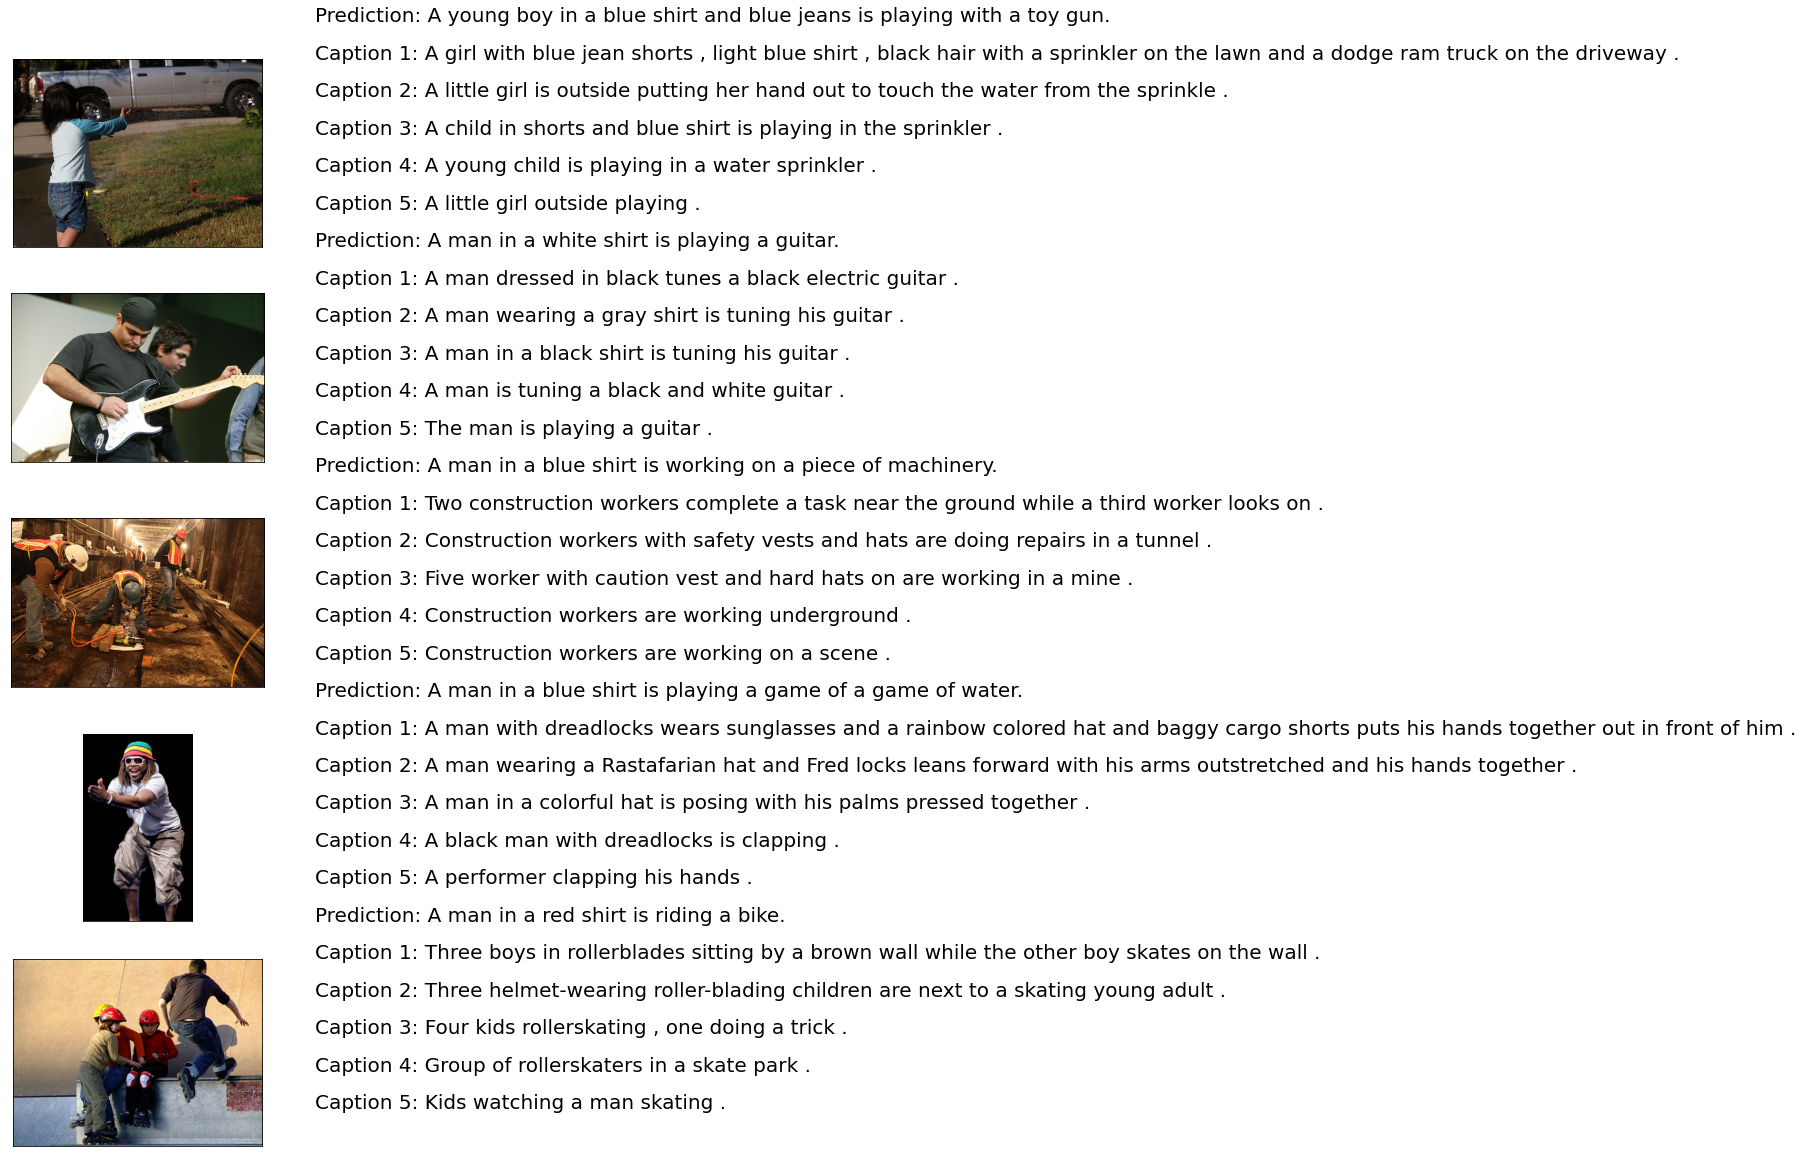

In [ ]:
# Muestro las predicciones del modelo para 5 fotos elegidas al azar.

random_test_keys = np.random.choice(test_keys, 5, replace = False)

npic = 5
count = 1
fig = plt.figure(figsize=(10,20))
for idx, key in enumerate(random_test_keys):
  image_path = 'caption_data/flickr30k_images/flickr30k_images/' + key + '.jpg'
  image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
  ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
  ax.imshow(np.squeeze(image))
  count += 1

  captions = [dct['text'] for dct in test_captions[test_captions['image_key'] == key]['caption_dict'].values[0]]

  ax = fig.add_subplot(npic,2,count)
  plt.axis('off')
  ax.plot()
  ax.set_xlim(0,1)
  ax.set_ylim(0,len(captions))
  for idx, caption in enumerate(captions):
    new_text = 'Caption ' + str(idx +1) + ': ' + caption
    ax.text(0,5-idx,new_text,fontsize=20)
  prediction = 'Prediction: ' + generate_caption(photo = test_encoded_img[key].reshape((1,2048)), model = captioning_model, token_to_id = training_token_to_id, id_to_token = id_to_token, max_length = max_length).capitalize()+'.'
  ax.text(0, len(captions)+1, prediction, fontsize=20)
  count += 1
plt.show()

# Testeo del modelo

In [ ]:
actual, predicted = list(), list()

for key in tqdm(test_keys):
  actual_captions = []
  caption_list = [c['text'].lower() for c in test_captions[test_captions['image_key'] == key]['caption_dict'].values[0]]
  for caption in caption_list:
    actual_captions.append(caption.split())
  pred = generate_caption(photo = test_encoded_img[key].reshape((1,2048)), model = captioning_model, token_to_id = training_token_to_id, id_to_token = id_to_token, max_length = max_length).split()
  actual.append(actual_captions)
  predicted.append(pred)

100%|██████████| 6357/6357 [1:36:19<00:00,  1.10it/s]


In [ ]:
print("\nBLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print("BLEU-3: %f" % corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0)))
print("BLEU-4: %f" % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))


BLEU-1: 0.534841
BLEU-2: 0.345926
BLEU-3: 0.221114
BLEU-4: 0.141046


# Referencias


- Flickr 30k Dataset: https://paperswithcode.com/paper/from-image-descriptions-to-visual-denotations
- GloVe Embeddings: https://nlp.stanford.edu/projects/glove/
- InceptionV3 Model: https://paperswithcode.com/method/inception-v3
- Score BLEU: https://aclanthology.org/P02-1040.pdf
- Image Captioning - TensorFlow: https://github.com/VinitSR7/Image-Caption-Generation
- Image Captioning - Notebook de referencia: https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/image_captioning.ipynb#scrollTo=IlUckK8Zfikv